# Full data fit
- a[J] is vector of county-specific baseline radon level. There are 84 counties in total.

In [9]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pystan

import radon

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


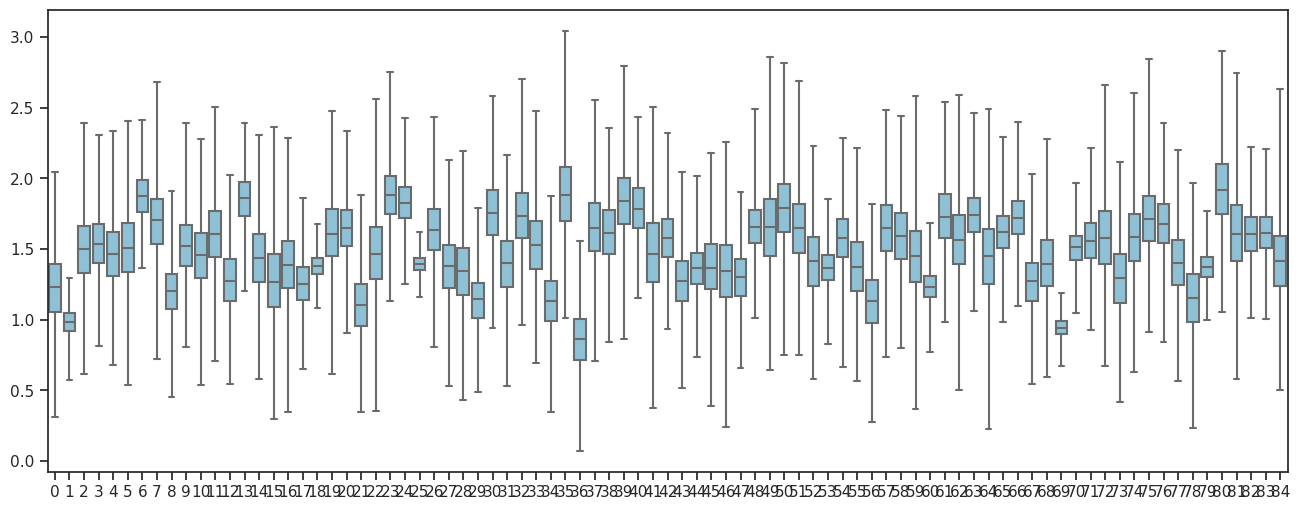

In [12]:
data_dict_ = radon.load_data()
path_with_data = 'stancache/weighted_radon.pkl'
if os.path.isfile(path_with_data):
    sm = pickle.load(open(path_with_data, 'rb'))
else:
    sm = pystan.StanModel(model_code=stan_representation)
    with open(path_with_data, 'wb') as f: pickle.dump(sm, f)

stanfit = sm.sampling(data=data_dict_,refresh=0, seed=0)

a_sample = pd.DataFrame(stanfit['a'])
sns.set(style="ticks", palette="muted", color_codes=True)
plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")
plt.show()

# Coreset fit for varying sizes
- at coreset size = 1, bassically we have information from just the prior (execpt for that one county)
    + note the scale of the latent variables, compared to the posterior on the full data
- as coreset size increases, the heterogeneity across the counties become more apparent

![Coreset = 1](results/opt_itrs%3D10_trial%3D0/coreset_M%3D1_var%3Da.png)

![Coreset = 37](results/opt_itrs%3D10_trial%3D0/coreset_M%3D34_var%3Da.png)

![Coreset = 67](results/opt_itrs%3D10_trial%3D0/coreset_M%3D67_var%3Da.png)

![Coreset = 100](results/opt_itrs%3D10_trial%3D0/coreset_M%3D100_var%3Da.png)

# Visualize dataset

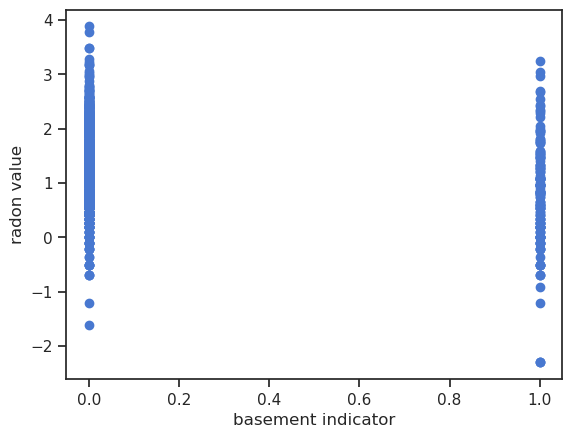

In [16]:
plt.figure()
plt.scatter(data_dict_['x'], data_dict_['y'])
plt.xlabel('basement indicator')
plt.ylabel('radon value')
plt.show()

# Number of observations in original group versus weighted number in coreset

In [17]:
coresetpath = "results/opt_itrs=10_trial=0/coreset_M=100.pkl"
coreset_dict_ = pickle.load(open(coresetpath, "rb"))
# print(coreset_dict_.keys())

dict_keys(['wts', 'pts', 'idcs', 'data_dict'])


In [25]:
print("Coreset indices", coreset_dict_["idcs"])
picked_counties = [data_dict_["county"][j] for j in coreset_dict_["idcs"]]
print(picked_counties)

Coreset indices [606 727  58 902 405  93 144 143 213 669 265 296 598 663 449 142 110 544
 645  46 424 684 514 390 535 251 617 480 412   5 434 406 471 664 129 870
 400  62  73 442 496 856 233 651 892 915 635 824 887 789 825 439 260 554
 805 509 153 417  79 227 839 372 629 395 612 249 492 383  88 465 605 421
 397   2 814 832 640 119 148 140 565 823 559 380 221 358 443 798 428 657
 131 552 458 413 376 602 484 508 473]
[63, 70, 3, 83, 33, 9, 17, 17, 19, 70, 26, 26, 61, 70, 42, 17, 11, 55, 67, 2, 37, 70, 52, 30, 54, 25, 64, 46, 35, 2, 39, 33, 45, 70, 14, 80, 32, 4, 7, 41, 49, 80, 22, 68, 83, 84, 66, 76, 81, 71, 77, 40, 25, 57, 72, 51, 18, 36, 7, 21, 79, 27, 66, 31, 64, 24, 48, 30, 8, 44, 62, 37, 31, 1, 74, 78, 67, 13, 18, 16, 59, 76, 58, 29, 20, 26, 41, 71, 38, 69, 14, 56, 43, 35, 28, 62, 47, 50, 45]


In [42]:
coreset_size = len(coreset_dict_["idcs"])
sum_per_county = {}
weighted_sum_per_county = {}
for j in range(coreset_size):
    picked_county = data_dict_["county"][coreset_dict_["idcs"][j]]
    if picked_county in weighted_sum_per_county:
        past_weighted_sum = weighted_sum_per_county[picked_county]
        past_sum = sum_per_county[picked_county]
    else:
        past_weighted_sum = 0
        past_sum = 0
    weighted_sum_per_county[picked_county] = past_weighted_sum + coreset_dict_["wts"][j]
    sum_per_county[picked_county] = past_sum + 1
    
print(weighted_sum_per_county)
print()
print(sum_per_county)

{63: 1.3286416744204679, 70: 114.13793091881492, 3: 0.6100849638195491, 83: 20.855272983315313, 33: 4.0456753592680466, 9: 19.762068677307216, 17: 101.63693750021474, 19: 47.66874364067517, 26: 78.38261429959293, 61: 25.08127288024665, 42: 2.746361622086349, 11: 4.2676037576086445, 55: 8.883122605134169, 67: 17.033642268611043, 2: 48.19962404383891, 37: 6.785062015268029, 52: 3.195251236097266, 30: 12.11189785569259, 54: 22.988986527266494, 25: 20.352721231329223, 64: 13.18024189278519, 46: 10.472496005087677, 35: 14.746058894705476, 39: 7.111172037907956, 45: 17.798488917815657, 14: 17.18233780995986, 80: 33.03382815032856, 32: 6.606101548538744, 4: 8.861063520233417, 7: 18.575213942010933, 41: 10.355114128240066, 49: 7.108539053515219, 22: 17.175394648073013, 68: 8.364756909877704, 84: 16.398659748814893, 66: 21.071912853365333, 76: 6.2619794745571244, 81: 2.7582918983908367, 71: 30.096472218023685, 77: 8.273891645530526, 40: 4.508514165246386, 57: 13.717579410855217, 72: 9.150601866

In [43]:
bins = range(1, np.amax(data_dict_["county"])+1)
x, _ = np.histogram(data_dict_["county"], bins)
print(x)

[  4  52   3   7   4   3  14   4  10   6   5   4   6  14   4   2   4  12
  63   3   9   6   2   9  14 105   6   5   3  11   5   4   4   3   7   2
   9   4   5   4   8   1   9   7  13   5   2   9  13   1   4   3   3  23
   8   3   6   4   4   2  32   5   3  11   2  14  13   8   4 116  25  10
   2   4   3   4   7   5   4  46   3   1  13  15]


[0, 0.019230769230769232, 0.6666666666666666, 0.14285714285714285, 0.25, 0, 0, 0.5, 0.1, 0.16666666666666666, 0, 0.25, 0, 0.07142857142857142, 0.5, 0, 0.25, 0.25, 0.031746031746031744, 0.3333333333333333, 0.1111111111111111, 0.16666666666666666, 0.5, 0, 0.07142857142857142, 0.01904761904761905, 0.5, 0.2, 0.3333333333333333, 0.09090909090909091, 0.4, 0.5, 0.25, 0.6666666666666666, 0, 1.0, 0.1111111111111111, 0.5, 0.2, 0.25, 0.125, 2.0, 0.1111111111111111, 0.14285714285714285, 0.07692307692307693, 0.4, 0.5, 0.1111111111111111, 0.07692307692307693, 1.0, 0.25, 0.3333333333333333, 0.3333333333333333, 0, 0.125, 0.3333333333333333, 0.16666666666666666, 0.25, 0.25, 0.5, 0, 0.2, 0.6666666666666666, 0.09090909090909091, 1.0, 0, 0.15384615384615385, 0.25, 0.25, 0.008620689655172414, 0.2, 0.2, 0.5, 0, 0.3333333333333333, 0, 0.2857142857142857, 0.2, 0.25, 0.021739130434782608, 0.6666666666666666, 1.0, 0, 0.13333333333333333]


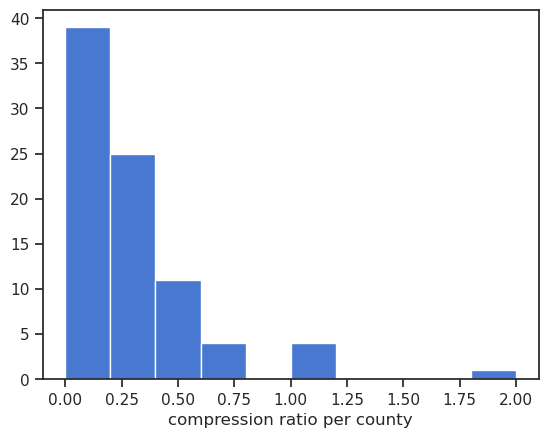

In [44]:
compression = []
for (county, val) in enumerate(x):
    if (county in sum_per_county):
        ratio = sum_per_county[county]/val
    else:
        ratio = 0
    compression.append(ratio)
print(compression)
plt.hist(compression)
plt.xlabel('compression ratio per county')
plt.show()

## Accuracy in county estimate versus number of coreset points